# Adjustment of an ARMA-GARCH model to CAC40 stock prices

## Introduction

This project focuses on the analysis and the modelisation of the financial time series of the  CAC40 returns stock price using python environment. Our analysis is realized in three main parts. 

We start the first part by a preliminary analysis of the daily closing stock prices and returns of CAC40. The stationarity of the return series is also investigated. The second part intends to fit an appropriate ARMA-GARCH model to the log-returns stock prices of the CAC40 and the last part focuses on using fitted model to predict future returns and prices of the CAC40 stock. 

## The python librairies

In [2]:
# Librairies


import pandas as pd
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()# To apply a seaborn wrapper over all subsequent plot

import statsmodels.api as sm

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import auto_arima

import pandas_datareader.data as web

from arch import arch_model
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy import stats
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error

from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

## Loading data

The data used to fit the models in this report are daily closing prices of the  CAC40 stock price from March 1st, 1990 to May 30th, 2022 which corresponds to `8182` dialy observations. The data is compiled from Yahoo finance.


In [3]:
# Loading data from yahoo finance
start = dt.datetime(1990,3,1)
end = dt.datetime(2022,5,30)
cac40 = web.DataReader('^FCHI', 'yahoo' ,start=start, end=end)
#prices = cac40['Close']
cac40.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1990-03-01,1838.0,1827.0,1836.0,1832.0,0.0,1832.0
1990-03-02,1860.0,1831.0,1831.0,1860.0,0.0,1860.0
1990-03-05,1874.0,1862.0,1866.0,1874.0,0.0,1874.0
1990-03-06,1875.0,1866.0,1869.0,1872.0,0.0,1872.0
1990-03-07,1881.0,1874.0,1874.0,1880.0,0.0,1880.0


In [4]:
# The shape of the data
cac40.shape

(8182, 6)

In [6]:
# Choose the closing prices
prices=pd.DataFrame(cac40["Close"])
prices.index

DatetimeIndex(['1990-03-01', '1990-03-02', '1990-03-05', '1990-03-06',
               '1990-03-07', '1990-03-08', '1990-03-09', '1990-03-12',
               '1990-03-13', '1990-03-14',
               ...
               '2022-05-17', '2022-05-18', '2022-05-19', '2022-05-20',
               '2022-05-23', '2022-05-24', '2022-05-25', '2022-05-26',
               '2022-05-27', '2022-05-30'],
              dtype='datetime64[ns]', name='Date', length=8182, freq=None)

In [7]:
# The tail of the data
prices.tail()

,Close
Date,
2022-05-24,6253.140137
2022-05-25,6298.640137
2022-05-26,6410.580078
2022-05-27,6515.750000
2022-05-30,6562.390137


In [8]:
# The shape of the data
prices.shape

(8182, 1)

In [9]:
# Ensure that the date are ordered in business week fashion i.e., 5 days a week
prices=prices.asfreq("B")
prices= prices.ffill()
prices.isna().sum()

Close    0
dtype: int64

### Plot of  the closing prices of Cac40 stock

Below is the plot of the price of the Cac40 stock index.

Text(0.5, 1.0, 'Daily prices from 1990-03-01 to 2022-05-05')

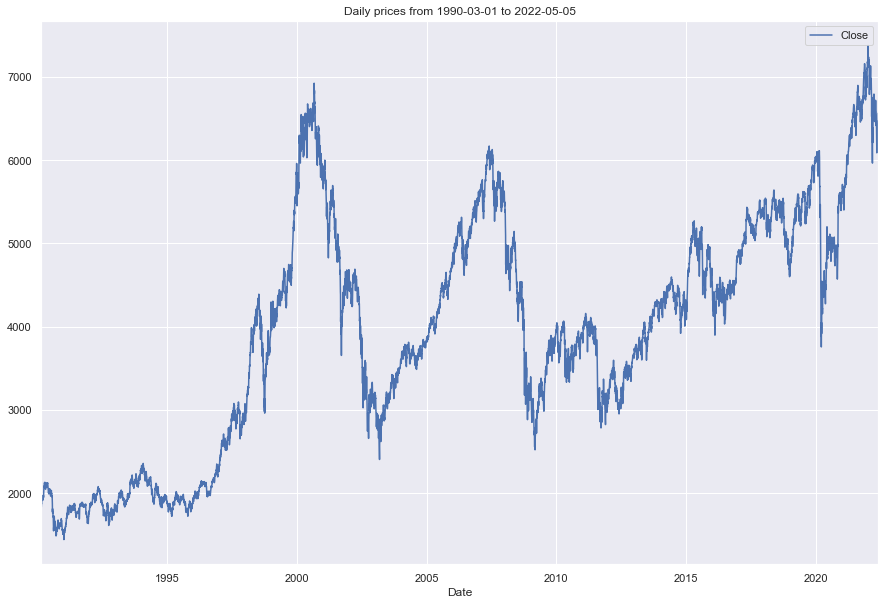

In [10]:
# Plot of the prices

ax = prices.plot(figsize=(15,10))
xlim = ax.set_xlim(prices.index.min(), prices.index.max())
ax.set_title("Daily prices from 1990-03-01 to 2022-05-05")

As we can see from the above plot, the Cac40 prices is relatively increasing with four major falling prices near 2004,2009, 2012 and 2020.

### Decomposition of the prices

Looking at the above plot of closing prices, it seems that there are some trend and seasonal component in the data. Let show that hidden repeating parterns with the function `seasonal_decompose()`.

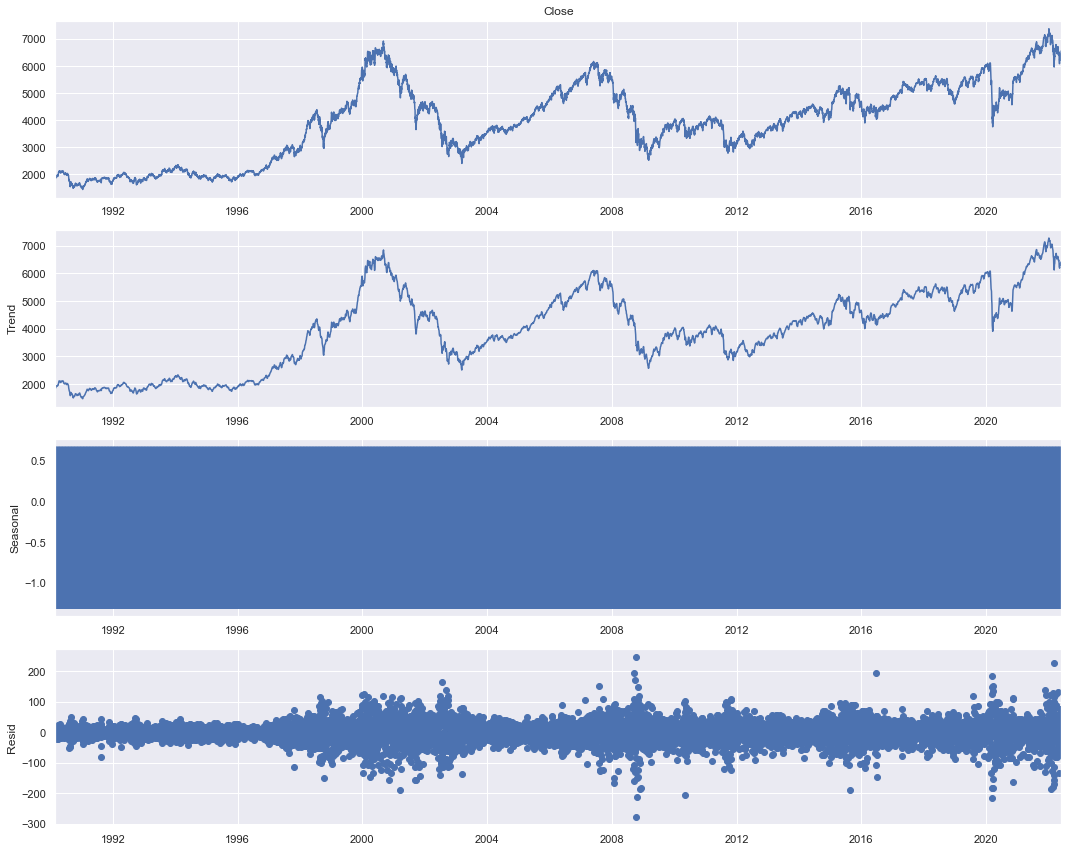

In [11]:
# The require package
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"]=(15,12)

decomp=seasonal_decompose(prices.Close, model="additive", period=5) # period=5 for weekly period
decomp.plot()
plt.show()

The seasonal and residuals component look strange. They seems odd, so we must examine that further by ploting only the first 50 values

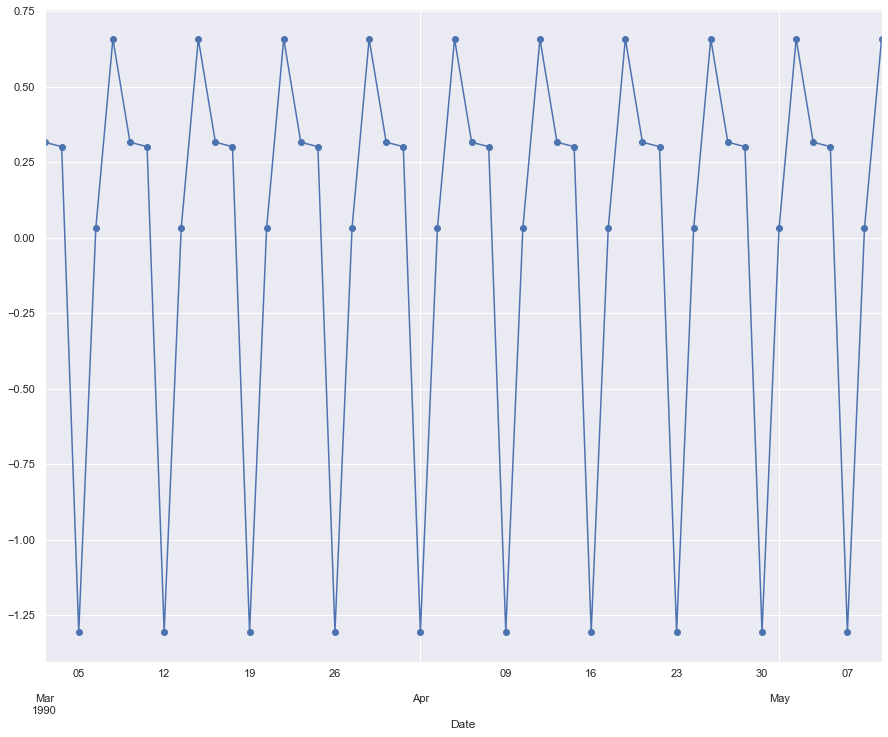

In [12]:
# first 50 values
decomp.seasonal[:50].plot(marker='o')
plt.show()

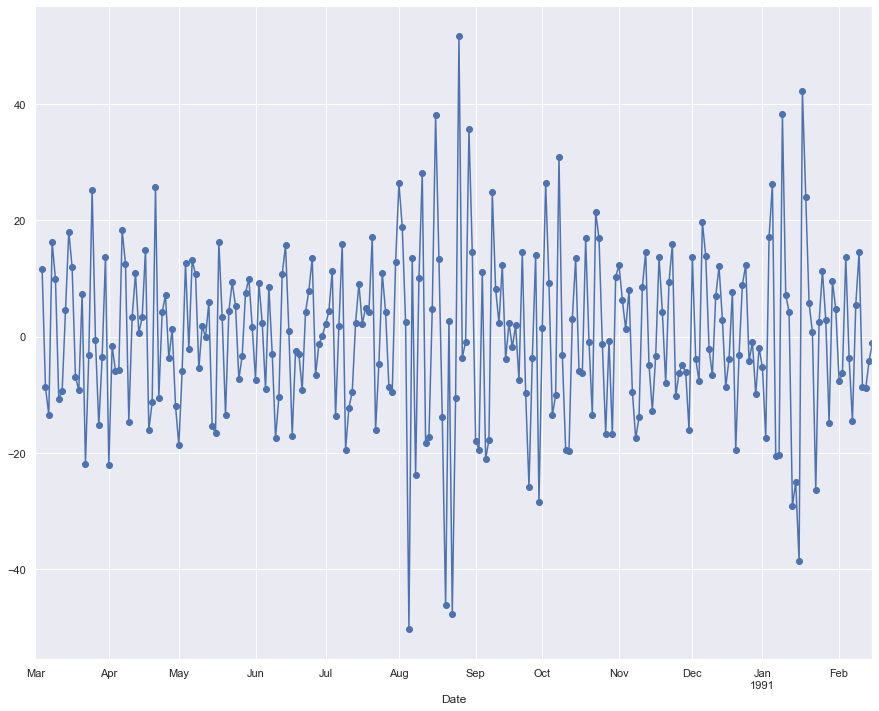

In [13]:
# Residual for the first year values

decomp.resid[:252].plot(marker='o')
plt.show()

## Returns

Here, we compute the returns and the log-returns.  Let us recall that the log-returns is computed by taking the natural logarithm of the ratio of two consecutive prices, as a good approximation of daily percentage changes in prices.

In fact, if we suppose that the price of the Cac40 stock at times $t$ is $S_t$, then the return $r_t$ is given by the following expression:

$$ r_t=\frac{S_t-S_{t-1}}{S_{t-1}} $$

The log-return $ r_t$ is given by:

$$ r_t=\ln(\frac{S_t}{S_{t-1}})  $$

For small prices change $(x\approx 0)$, theses two definitions are not important as $\ln(1+x)\approx x$.

In [14]:
# Daily returns as percentage price changes
prices['Return'] = 100 * (prices['Close'].pct_change())
prices.head()

,Close,Return
Date,,
1990-03-01,1832.0,NaN
1990-03-02,1860.0,1.528384
1990-03-05,1874.0,0.752688
1990-03-06,1872.0,-0.106724
1990-03-07,1880.0,0.427350


In [15]:
# Daily log-returns
prices['Log_Return'] = np.log(prices['Close']).diff().mul(100) 
prices.head()

,Close,Return,Log_Return
Date,,,
1990-03-01,1832.0,NaN,NaN
1990-03-02,1860.0,1.528384,1.516822
1990-03-05,1874.0,0.752688,0.749870
1990-03-06,1872.0,-0.106724,-0.106781
1990-03-07,1880.0,0.427350,0.426440


### Missing values

In [16]:
# Count the nombers of missing values
prices.isnull().sum()

Close         0
Return        1
Log_Return    1
dtype: int64

In [17]:
# drop the row with missing values
prices=prices.dropna()
prices.isnull().sum()

Close         0
Return        0
Log_Return    0
dtype: int64

Text(0.5, 1.0, 'Daily  prices ')

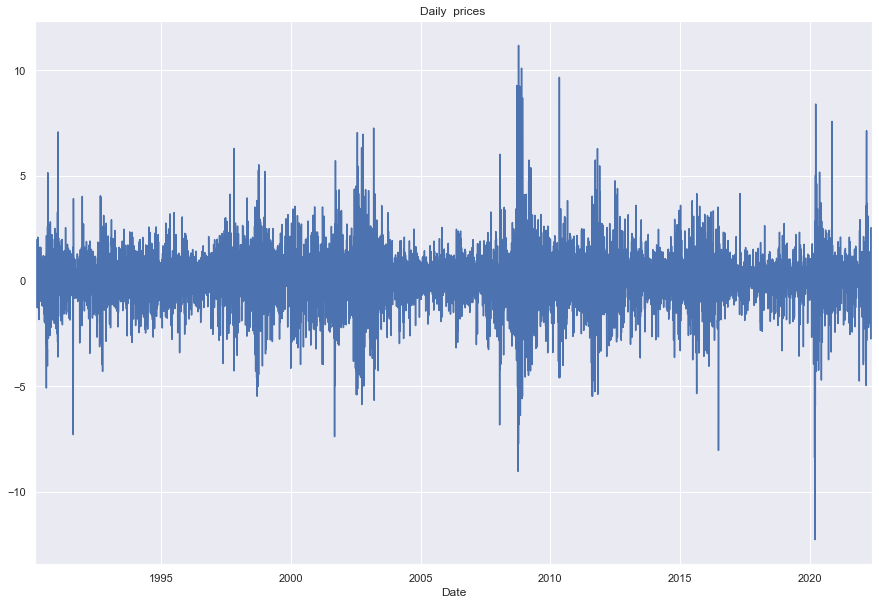

In [18]:
# Plots of Returns 

# setting the figure size
plt.rcParams["figure.figsize"]=(15,10)


# plot Cac40 prices
ax=prices["Return"].plot()
ax.set_title("Daily  prices ")




Text(0.5, 1.0, 'Daily Log Returns ')

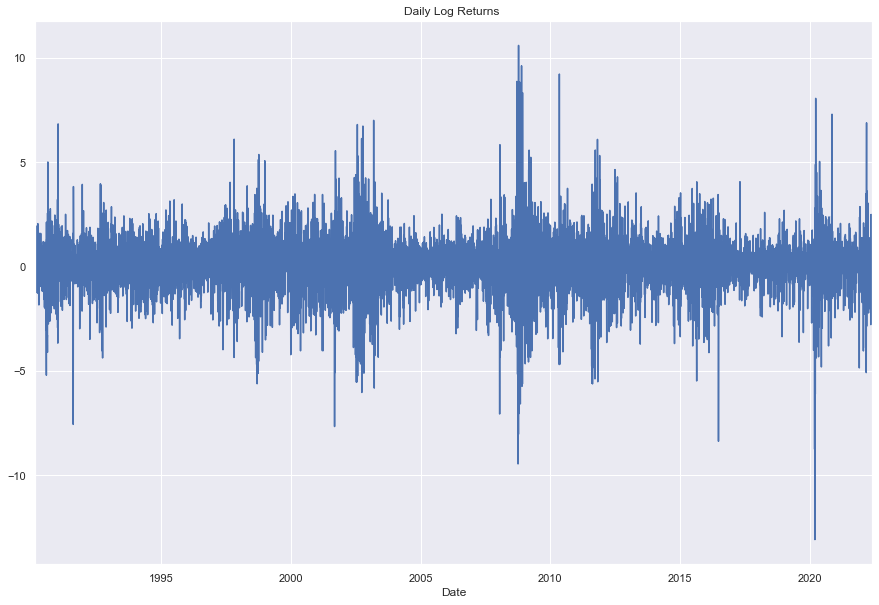

In [19]:
# Plots of daily Log Returns 

# setting the figure size
plt.rcParams["figure.figsize"]=(15,10)


# plot Cac40 prices
ax=prices["Log_Return"].plot()
ax.set_title("Daily Log Returns ")


### Volatility




In [20]:
# Daily volatility on log-returns
prices["Log_Return_vol"]=(prices['Log_Return']-prices['Log_Return'].mean())**2
prices.head()

/Users/cyrillesimeu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Close,Return,Log_Return,Log_Return_vol
Date,,,,
1990-03-02,1860.0,1.528384,1.516822,2.254965
1990-03-05,1874.0,0.752688,0.749870,0.539786
1990-03-06,1872.0,-0.106724,-0.106781,0.014871
1990-03-07,1880.0,0.427350,0.426440,0.169144
1990-03-08,1917.0,1.968085,1.948969,3.739585


Text(0.5, 1.0, 'Daily Log Returns volatility')

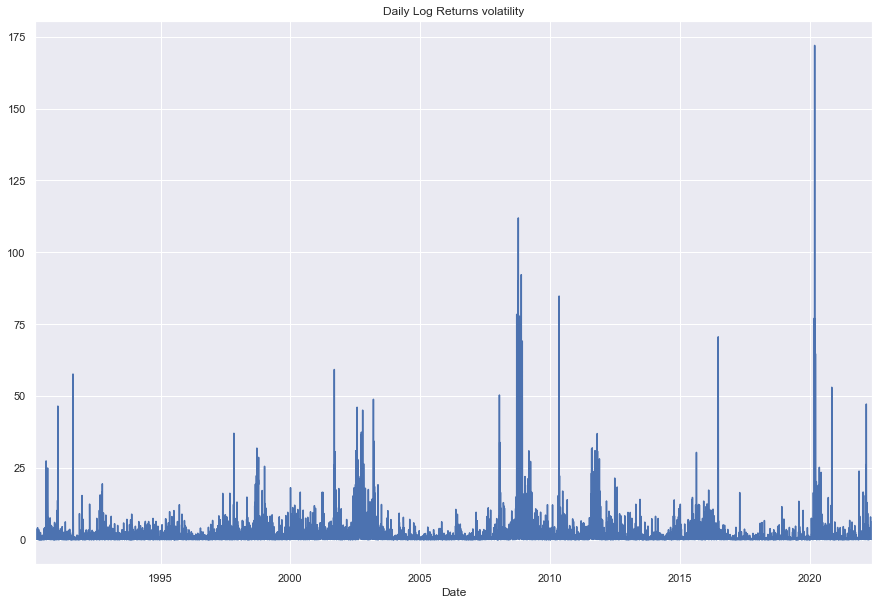

In [21]:
# Plot the daily volatility

 

# setting the figure size
plt.rcParams["figure.figsize"]=(15,10)


# plot Cac40 prices
ax=prices["Log_Return_vol"].plot()
ax.set_title("Daily Log Returns volatility")


The plot of daily volatility shows that the market was very unstable during periods near `2004`, `2009` and the covid 19 period in `2020`. 


## Preliminaries analysis

### Descriptive statistics

The table below shows the descriptive statistics of the log-returns of the CAC40 prices with the maximal daily log-return in the sample being `10.594590` and the minimal daily log-return being `-13.098349`. This shows an extremely high volatility on this financial asset. The mean log-return is `0.015168`, with a quite high standard deviation of `1.353746`. The  Jarque-Bera statistic is `12719.426806`, which indicates that it is very far  from normality `(>>599)`. The log-returns are also negatively skewed, while the excess kurtosis suggests evidence of a leptokurtic distribution.

In [23]:
# Statistique descriptives
desc=prices['Log_Return'].describe()
# remove element from the descriptive statistic
desc.pop("25%")
desc.pop("50%")
desc.pop("75%")
# Compute du skewness
desc["Skewness"]=skew(prices['Log_Return'], axis=0, bias=True)
# Compute the kurtosis
desc["Kurtosis"]=kurtosis(prices['Log_Return'], axis=0, bias=True)
# Compute the Jarque Bera statistic and add to the list
jarque_bera_test=stats.jarque_bera(prices['Log_Return'])
desc["Jarque Bera"]=jarque_bera_test[0]
# transform the list to a dataframe
desc=pd.DataFrame(desc.items(), columns=[" ", ""])
desc.set_index(" ", inplace=True)
#desc.index.name=None
desc

,
,
count,8412.000000
mean,0.015168
std,1.353746
min,-13.098349
max,10.594590
Skewness,-0.196932
Kurtosis,6.011177
Jarque Bera,12719.426806


The distribution of the density curves and histogram of log-return and volatility below shows that log-return distribution seems normal with a mean near to zero and the log-return volatility have a right-skewed normal distribution.

/Users/cyrillesimeu/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/cyrillesimeu/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


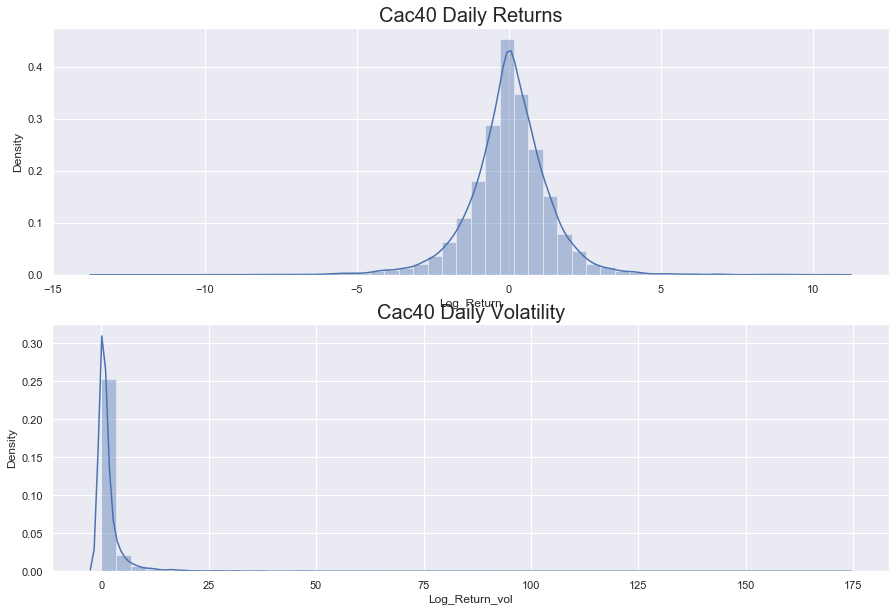

In [24]:
plt.rcParams["figure.figsize"]=(15,10)

# The subplots
fig, axes=plt.subplots(2,1)

sns.distplot(prices.Log_Return, ax=axes[0])
sns.distplot(prices.Log_Return_vol, ax=axes[1])

# Title of each subplot

axes[0].set_title("Cac40 Daily Returns", size=20)
axes[1].set_title("Cac40 Daily Volatility", size=20)

plt.show()


### Stationarity

Before modeling this time series, we need to check the stationarity. There are many statistical and econometric methods for checking stationarity. Let us recall that  __stationary time series__ are time series that do not have trend and seasonal effects. Amongst statistical methods used to check stationarity of a time series, we have the __Augmented Dickey-Fuller test__. It is a statistical test which uses an autoregressive model and optimizes an information criterion across multiple different lag values. The null hypothesis of the test is that __the time series can be represented by a unit root, meaning that it is non stationary__, the alternative hypothesis of the ADF test is that the null hypothesis is rejeted, maning that the time series is stationary i.e. doesn't have a unit root and does not have time-dependent structure.

-  __p-value>0.05 :__ Fail to reject the null hypothesis, namely, the data has a unit root and is non-stationary.  

- __p.value<=0.05 :__ reject the null hypothesis, the time series does not have a unit root and is stationary


Based on the results of the Augmented Dickey– Fuller (ADF) tests as shown, we fail to accept the null hypothesis of a unit root for the returns, hence, stationarity is guaranteed for the log-return series of CAC40.


In [25]:
test_result=adfuller(prices["Log_Return"])
dict1={"ADF Statistic": test_result[0],
        "p-value": test_result[1],
        "Lag used": test_result[2],
        "Observed used": test_result[3]}
for key, value in test_result[4].items():
    dict1["Critiacal %s" % key]=value
tab=pd.DataFrame(dict1.items(), columns=[" "," "])
tab

,,
0,ADF Statistic,-40.178924
1,p-value,0.000000
2,Lag used,5.000000
3,Observed used,8406.000000
4,Critiacal 1%,-3.431128
5,Critiacal 5%,-2.861884
6,Critiacal 10%,-2.566953


### Analysis of the volatility times series

The following figure illustrates  volatility clustering and a fluctuate around a constant level. We can noticed that large changes tend to cluster together, and small changes tend to cluster together. This indicates that the series exhibits conditional heteroscedasticity.

Text(0.5, 1.0, 'Daily Log Returns volatility')

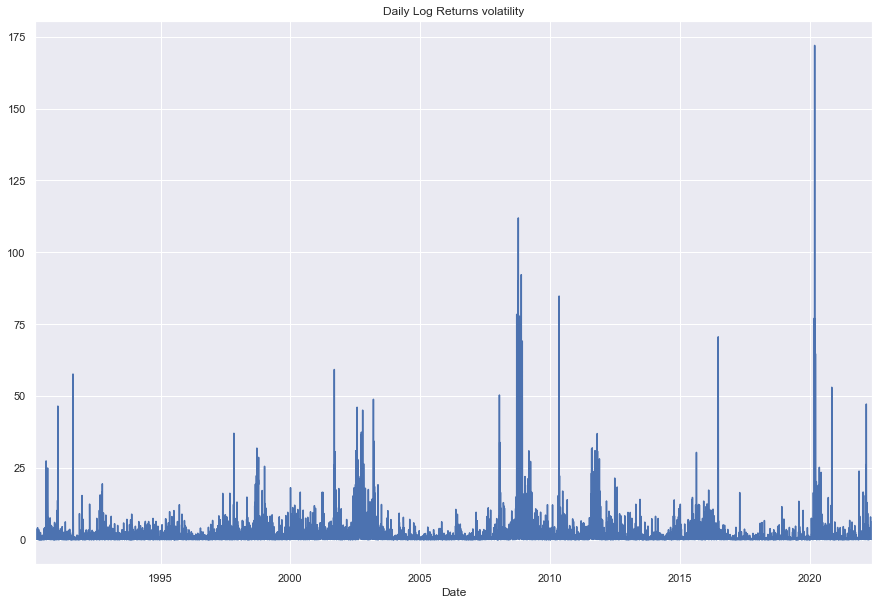

In [26]:
# Plot the daily volatility

 

# setting the figure size
plt.rcParams["figure.figsize"]=(15,10)


# plot Cac40 prices
ax=prices["Log_Return_vol"].plot()
ax.set_title("Daily Log Returns volatility")

### Autocorrelation and partial autocorrelation of the Daily volatility

The following sample of `ACF` and `PACF` show significant autocorrelation in the log returm volatility. We will confirm that analysis by using a statistical __`Ljung-Box Q-test`__   for autocorrelation.

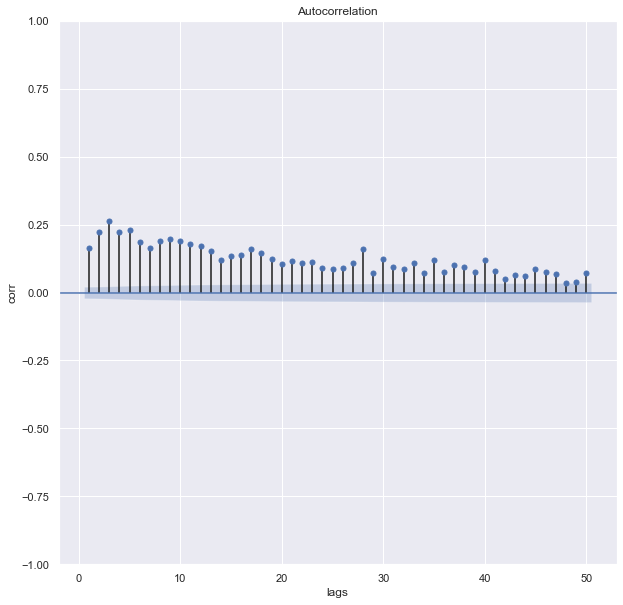

In [27]:
#  autocorrelation function of the Daily volatility

# setting the figure size
plt.rcParams["figure.figsize"]=(10,10)

plot_acf(prices["Log_Return_vol"],zero=False, lags=50)# zero=False do not plot the fist lag
plt.xlabel('lags')
plt.ylabel('corr')
plt.show()
    


/Users/cyrillesimeu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


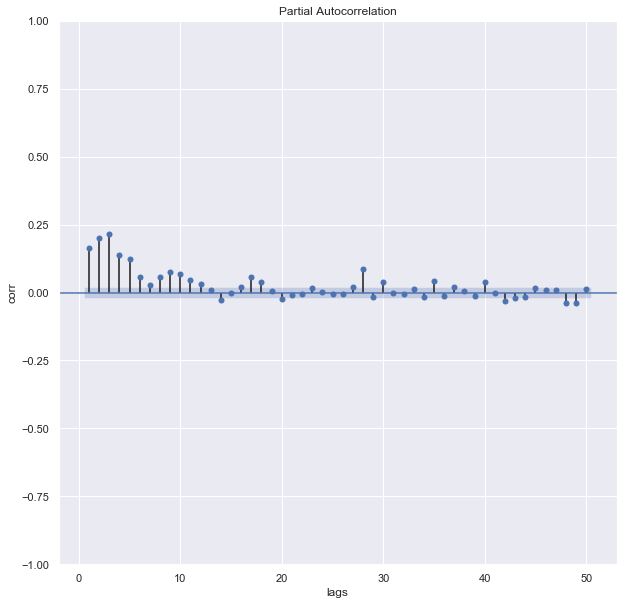

In [28]:
# setting the figure size
plt.rcParams["figure.figsize"]=(10,10)

# The partial autocorrelation function of the squared returns
plot_pacf(prices["Log_Return_vol"],zero=False, lags=50)
plt.xlabel('lags')
plt.ylabel('corr')
plt.show()

###  The Ljung-Box Q-test 

Ljung-Box test is a statistical test which is used to check whether a time series contains an autocorrelation. The null hypothesis $H_0$ is that the residuals are independently distributed and the alternative hypothesis $H_1$ is that the residuals are not independently distributed and exhibit a serial correlation.

In [590]:
acorr_ljungbox(prices["Log_Return_vol"], lags=[i for i in range(1,11)], return_df=True)

,lb_stat,lb_pvalue
1,228.608628,1.198896e-51
2,645.602084,6.445977e-141
3,1228.618892,4.526882e-266
4,1639.647461,0.000000e+00
5,2081.687013,0.000000e+00
6,2371.608248,0.000000e+00
7,2597.193461,0.000000e+00
8,2900.442215,0.000000e+00
9,3229.886841,0.000000e+00
10,3529.079459,0.000000e+00


As we can see from the above p-values of the Ljung-Box text, the null hypothesis $H_0$ is rejected. This indicates that the log-return volatility contains autocorrelation.

As showed in the `ACF` and `PACF` plot of the log returns daily volatility and the results of the __Ljung-Box test__, there is an autocorrelation. Now, we are going to build a model that will attempt to capture the autocorrelation of log-returns volatility, clustering volatility, as well as the heteroscedasticity.

The significance of the lags in bot of the `ACF` and `PACF` of the  log-returns volatility suggest to start with an `ARMA(p,q)`  model, as we know that `ARMA` models are used to model the conditional mean of the process given past information, which however, assumes the conditional variance given the past information is constant.

The log returns in this case can be described as in the equation:

$$r_t=\mu_t+ \epsilon_t $$

where $\mu_t$ is the conditional expectation of the retruns given past information and $\epsilon_t$ is the innovations, or the residuals of the log returns.

`ARMA(p,q)` model alone will fails to capture the volatility clustering behavior and the heteroscedasticity. Thus after the ajustement of the `ARMA(p,q)` process to the log returns of the CAC40 time series, we will use  a `GARCH` model to the residual $\epsilon_t$ of the `ARMA(p,q)` model fitted.

Let us recall that a process $\{\epsilon_t\}$ is a GARCH(p,q)-process if $\{\epsilon_t\}$ is the solution of the equation

$$\epsilon_t=\sigma_t Z_t\qquad \{Z_t\}\sim_{\text{iid}} N(0,1)$$
and where $0<\sigma_t=\sigma_t(\epsilon_s,s<t)$ is defined via

$$ \sigma_t^2=\alpha_0+\displaystyle\sum_{i=1}^p\alpha_i\epsilon_{t-i}^2+\sum_{j=1}^q\beta_j\sigma_{t-j}^2,\qquad \alpha_0>0,\alpha_i,\beta_j>0  $$
GARCH(p,q) process have the following properties  

- $\{\epsilon_t\}$ is mean-zero, uncorrelated process (not independant nor iddentically distributed)  

- $\{ \epsilon_t^2 \}$ is an `ARMA(m,q)` process with $m=\max(p,q)$ because

$$\epsilon_t^2=\alpha_0+\displaystyle\sum_{i=1}^m(\alpha_i+\beta_i)\epsilon_{t-i}^2+\sum_{j=1}^q\beta_j\eta_{t-j}^2 +\eta_t$$
where the innovations $\{\eta_t=\epsilon_t^2-\sigma_t^2\}$ are mean-zero uncorrelated.`





## Split data into train and test

We split data into train and test sets. An alternative way is to use the function `train_set_split` of  the librairy `pmdarima` to split the data into train and test sets. We choose a one year   observations for the test set.

In [29]:
prices.tail(252)

,Close,Return,Log_Return,Log_Return_vol
Date,,,,
2021-06-11,6600.660156,0.827465,0.824060,0.654307
2021-06-14,6616.350098,0.237703,0.237421,0.049396
2021-06-15,6639.520020,0.350192,0.349580,0.111831
2021-06-16,6652.649902,0.197753,0.197558,0.033266
2021-06-17,6666.259766,0.204578,0.204369,0.035797
...,...,...,...,...
2022-05-24,6253.140137,-1.660708,-1.674652,2.855493
2022-05-25,6298.640137,0.727634,0.725000,0.503861
2022-05-26,6410.580078,1.777208,1.761600,3.050025


In [30]:
# Split the data

r_train=prices.loc[: "2021-06-11"]
r_test=prices.loc["2021-06-14":]


In [31]:
# The train set
r_train

,Close,Return,Log_Return,Log_Return_vol
Date,,,,
1990-03-02,1860.000000,1.528384,1.516822,2.254965
1990-03-05,1874.000000,0.752688,0.749870,0.539786
1990-03-06,1872.000000,-0.106724,-0.106781,0.014871
1990-03-07,1880.000000,0.427350,0.426440,0.169144
1990-03-08,1917.000000,1.968085,1.948969,3.739585
...,...,...,...,...
2021-06-07,6543.560059,0.428198,0.427283,0.169839
2021-06-08,6551.009766,0.113848,0.113783,0.009725
2021-06-09,6563.450195,0.189901,0.189721,0.030469


In [32]:
# Checking wheter null values appear in the train set
r_train.isnull().sum()

Close             0
Return            0
Log_Return        0
Log_Return_vol    0
dtype: int64

In [33]:
# The test set
r_test

,Close,Return,Log_Return,Log_Return_vol
Date,,,,
2021-06-14,6616.350098,0.237703,0.237421,0.049396
2021-06-15,6639.520020,0.350192,0.349580,0.111831
2021-06-16,6652.649902,0.197753,0.197558,0.033266
2021-06-17,6666.259766,0.204578,0.204369,0.035797
2021-06-18,6569.160156,-1.456583,-1.467295,2.197698
...,...,...,...,...
2022-05-24,6253.140137,-1.660708,-1.674652,2.855493
2022-05-25,6298.640137,0.727634,0.725000,0.503861
2022-05-26,6410.580078,1.777208,1.761600,3.050025


In [596]:

# Alternative way of splitting data using a function

#r_train, r_test = train_test_split(prices, test_size=251)


In [34]:
# Checking wheter there are null values in the test set
r_test.isnull().sum()

Close             0
Return            0
Log_Return        0
Log_Return_vol    0
dtype: int64

# The ARMA(p,q) process

## Parameters Estimation for the ARMA(p,q) Model

In order to adjust an `ARMA(p,q)` process to the log-returns of our series, we are  going to use the function `SARIMAX` of the package  `statsmodel`. Let us plot the correlogram of the log-return.

### ACF and PACF of log-returns

As we can see in the figure below, there are not significant lags on both of the ACF and the PACF functions. So, we will fit several ARMA model to our series and try to find the best one by using some information criterion. 

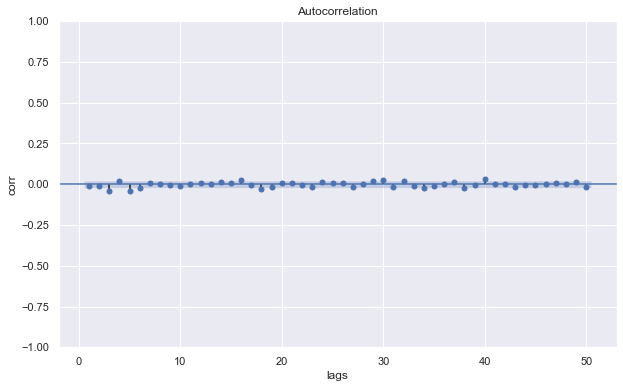

/Users/cyrillesimeu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


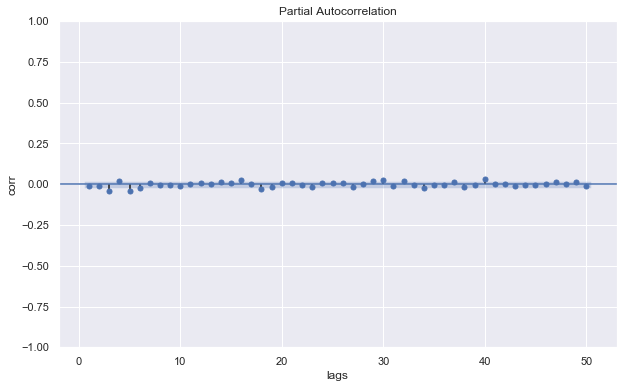

In [35]:
#  autocorrelation function of the Daily volatility

# setting the figure size
plt.rcParams["figure.figsize"]=(10,6)

# acf plot
plot_acf(r_train["Log_Return"],zero=False, lags=50)# zero=False do not plot the fist lag
plt.xlabel('lags')
plt.ylabel('corr')
plt.show()



# pcaf plot
plot_pacf(r_train["Log_Return"], zero=False,lags=50)# zero=False do not plot the fist lag
plt.xlabel('lags')
plt.ylabel('corr')
plt.show()
plt.show()

### Table of metrics

In [36]:
# package
from statsmodels.tsa.statespace.sarimax import SARIMAX

table_of_metric=pd.DataFrame( {"Model":["AIC","BIC","HQIC", "Log Likelihood"]}) 
table_of_metric.set_index("Model", inplace=True)

for p in range(0,4):
    for q in range(0,4):
        print("#"*80,"\n")
        print(" "*30,"ARMA(%d,%d)" % (p,q)," "*40,"\n")
        print("#"*80)
        # define the model
        model=SARIMAX(r_train["Log_Return"], order=(p,0,q))
        # fitting the model
        model_result=model.fit()
        # values of metric
        table_of_metric["ARMA(%d,%d)" % (p,q)]=[model_result.aic, model_result.bic, model_result.hqic, model_result.llf]
        # Print model summary
        print(model_result.summary())
tab=table_of_metric.T
tab

################################################################################ 

                               ARMA(0,0)                                          

################################################################################
                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                 8161
Model:                        SARIMAX   Log Likelihood              -14059.411
Date:                Tue, 14 Jun 2022   AIC                          28120.821
Time:                        22:51:41   BIC                          28127.828
Sample:                    03-02-1990   HQIC                         28123.217
                         - 06-11-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                 8161
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -14059.149
Date:                Tue, 14 Jun 2022   AIC                          28122.297
Time:                        22:51:46   BIC                          28136.311
Sample:                    03-02-1990   HQIC                         28127.089
                         - 06-11-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0080      0.007     -1.098      0.272      -0.022       0.006
sigma2         1.8360      0.014    127.140      0.000       1.808       1.864
Ljung-Box (L1) (Q):                   0.00   Jarque-

/Users/cyrillesimeu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/cyrillesimeu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                 8161
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -14054.258
Date:                Tue, 14 Jun 2022   AIC                          28114.516
Time:                        22:51:49   BIC                          28135.537
Sample:                    03-02-1990   HQIC                         28121.704
                         - 06-11-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8111      0.064     12.638      0.000       0.685       0.937
ma.L1         -0.8319      0.060    -13.820      0.000      -0.950      -0.714
sigma2         1.8337      0.014    127.683      0.0

/Users/cyrillesimeu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/cyrillesimeu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                 8161
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -14053.217
Date:                Tue, 14 Jun 2022   AIC                          28114.435
Time:                        22:52:00   BIC                          28142.463
Sample:                    03-02-1990   HQIC                         28124.019
                         - 06-11-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7701      0.069     11.109      0.000       0.634       0.906
ar.L2         -0.0177      0.008     -2.205      0.027      -0.033      -0.002
ma.L1         -0.7794      0.068    -11.411      0.0

/Users/cyrillesimeu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                 8161
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -14054.239
Date:                Tue, 14 Jun 2022   AIC                          28118.479
Time:                        22:52:05   BIC                          28153.514
Sample:                    03-02-1990   HQIC                         28130.459
                         - 06-11-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1821      0.069     -2.649      0.008      -0.317      -0.047
ar.L2          0.8124      0.066     12.372      0.000       0.684       0.941
ma.L1          0.1617      0.065      2.488      0.0

/Users/cyrillesimeu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/cyrillesimeu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                 8161
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -14047.252
Date:                Tue, 14 Jun 2022   AIC                          28106.504
Time:                        22:52:18   BIC                          28148.546
Sample:                    03-02-1990   HQIC                         28120.880
                         - 06-11-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0167      0.098     -0.172      0.864      -0.208       0.175
ar.L2          0.4605      0.105      4.388      0.000       0.255       0.666
ar.L3         -0.0435      0.008     -5.693      0.0

Model,AIC,BIC,HQIC,Log Likelihood
"ARMA(0,0)",28120.821212,28127.828334,28123.217243,-14059.410606
"ARMA(0,1)",28122.283289,28136.297533,28127.075352,-14059.141645
"ARMA(0,2)",28122.921116,28143.942482,28130.109209,-14058.460558
"ARMA(0,3)",28109.187369,28137.215857,28118.771494,-14050.593684
"ARMA(1,0)",28122.297068,28136.311312,28127.089130,-14059.148534
"ARMA(1,1)",28114.516099,28135.537465,28121.704192,-14054.258049
"ARMA(1,2)",28120.643389,28148.671877,28130.227514,-14056.321695
"ARMA(1,3)",28104.109776,28139.145386,28116.089932,-14047.054888
"ARMA(2,0)",28123.023142,28144.044507,28130.211235,-14058.511571
"ARMA(2,1)",28114.434611,28142.463099,28124.018736,-14053.217305


The best ARMA(p,q) model is the one with a lower __AIC__ and a greater __Log Likelihood__. Base on the __AIC__ criterion, the ARMA(3,3) is then the model we must choose. We can do more and let the programme find the best model for us. For that, we use the package `pmdarima` which internally wraps the statsmodel package and directly return the best model based on the combinaison of all information criteria such as `AIC, BIC, HQIC` and `Log Likelihood`.  

The package `pmdarima` is interesting as it finds the optimal `ARIMA(p,0,q)` parameters for us. As you can see below, the best model fitted using the package `pmdarima` is `ARMA(3,1)`. This is a more parcimonous model.  


In [37]:
# Fit a simple auto_arima model
arima_model = auto_arima(r_train["Log_Return"])
arima_model

ARIMA(order=(3, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### The model ARMA(3,3) results fitted with the  statsmodel package

In [38]:
# Defining the model
modelArma33WithStatsmodel=SARIMAX(r_train["Log_Return"], order=(3,0,3))
# fiting the model
modelArma33ResultWithStatmodel=modelArma33WithStatsmodel.fit()
# Printing the model summary
print(modelArma33ResultWithStatmodel.summary())


                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                 8161
Model:               SARIMAX(3, 0, 3)   Log Likelihood              -14042.906
Date:                Tue, 14 Jun 2022   AIC                          28099.812
Time:                        22:55:39   BIC                          28148.861
Sample:                    03-02-1990   HQIC                         28116.584
                         - 06-11-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4442      0.094     -4.714      0.000      -0.629      -0.260
ar.L2          0.2873      0.093      3.079      0.002       0.104       0.470
ar.L3          0.4212      0.090      4.654      0.0

If we set the confident level to `5%`, we see that the $P> \bar Z \bar $ column values are all less than `0.05`. This indicates that the coefficients of the `ARMA(3,3)` model fitted using the package `statsmodel` are all significant.

### The model ARMA(3,1) results fitted with the pmdarima package

In [39]:
# defining the model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8161
Model:               SARIMAX(3, 0, 1)   Log Likelihood              -14047.889
Date:                Tue, 14 Jun 2022   AIC                          28105.778
Time:                        22:56:17   BIC                          28140.814
Sample:                             0   HQIC                         28117.759
                               - 8161                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5036      0.101     -4.988      0.000      -0.701      -0.306
ar.L2         -0.0169      0.008     -2.200      0.028      -0.032      -0.002
ar.L3         -0.0505      0.007     -7.616      0.000      -0.063      -0.037
ma.L1          0.4962      0.101      4.921      0.000       0.299       0.694
sigma2         1.8309      0.014    126.887      0.000       1.803       1.859
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12453.35
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -0.24
Prob(H) (two-sided):                  0.04   Kurtosis:                         9.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The above summary table shows that all the coefficients of the model are significant.

For the next step of our analysis, we are going to use the `ARMA(3,1)` model as it is parcimonous. The difference between information criteria values of both models are not so significant.


## Prediction of the ARMA(3,1) model and confidence intervals

We use the `ARMA(3,1)` model to forecast the returns for the `test set` and to generate the confidence intervals.

### Forecasting the returns of the test set

In [40]:
# Defining the model
model31=SARIMAX(r_train["Log_Return"], order=(3,0,1))
# fiting the model
modelArma31=model31.fit()
# Building forcast object to generate confidence intervals
modelArma31Forecast=modelArma31.get_forecast(len(r_test["Log_Return"].index))
# Confidence level of 95%
modelArma31Predictions=modelArma31Forecast.conf_int(alpha=0.05)
modelArma31Predictions["Predictions"]=modelArma31.predict(start = r_test.index[0], end = r_test.index[-1])
pd.DataFrame(modelArma31Predictions)
#Arma31Predictions=modelArma31.conf_int(alpha=0.05)

#Arma31Predictions["Predictions"]=modelArma31.predict()
#Arma31Predictions


,lower Log_Return,upper Log_Return,Predictions
2021-06-14,-2.664007,2.640052,-1.197771e-02
2021-06-15,-2.646909,2.657294,5.192821e-03
2021-06-16,-2.696331,2.608331,-4.400025e-02
2021-06-17,-2.632188,2.677539,2.267549e-02
2021-06-18,-2.666480,2.644601,-1.093948e-02
...,...,...,...
2022-05-24,-2.655776,2.655776,-2.138233e-54
2022-05-25,-2.655776,2.655776,1.306741e-54
2022-05-26,-2.655776,2.655776,-7.985901e-55
2022-05-27,-2.655776,2.655776,4.880433e-55


In [41]:
modelArma31Predictions.loc[:,"lower Log_Return"]

2021-06-14   -2.664007
2021-06-15   -2.646909
2021-06-16   -2.696331
2021-06-17   -2.632188
2021-06-18   -2.666480
                ...   
2022-05-24   -2.655776
2022-05-25   -2.655776
2022-05-26   -2.655776
2022-05-27   -2.655776
2022-05-30   -2.655776
Freq: B, Name: lower Log_Return, Length: 251, dtype: float64

In [42]:
arma_true=r_test["Log_Return"].values
arma_pred=modelArma31Predictions["Predictions"].values

In [43]:
# The RMSE for the prediction

arma_rmse=np.sqrt(mean_squared_error(arma_true, arma_pred))

print("The RMSE for the prediction is ", arma_rmse)


The RMSE for the prediction is  1.311720675017241


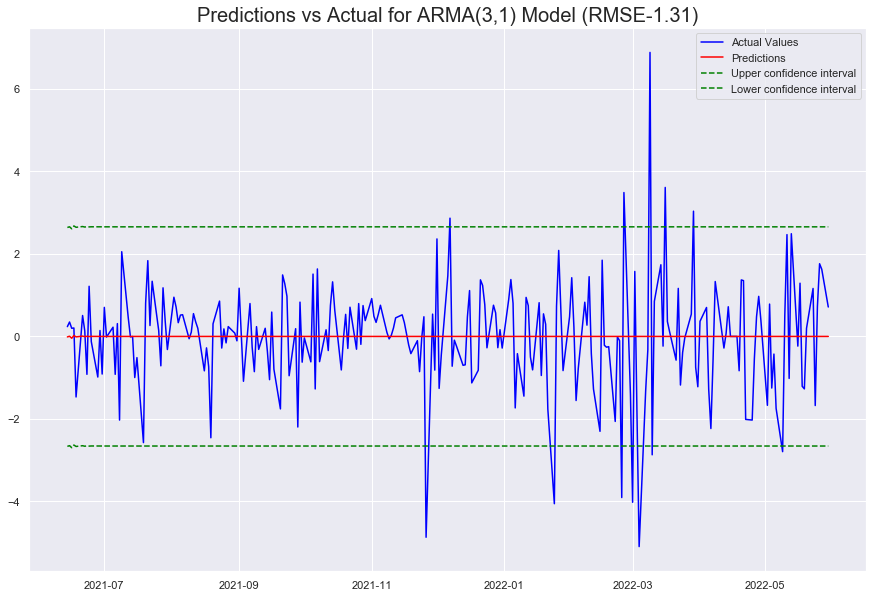

In [44]:
# Plotting forecasts

plt.rcParams["figure.figsize"]=(15,10)

# Plot the actuals values

plt.plot(r_test["Log_Return"], color="blue", label="Actual Values")

# Plot the forcast and the confidence intervals

plt.plot(modelArma31Predictions["Predictions"], color="red", label="Predictions")
plt.plot(modelArma31Predictions["upper Log_Return"], color="green",linestyle="--", label="Upper confidence interval")
plt.plot(modelArma31Predictions["lower Log_Return"], color="green",linestyle="--", label="Lower confidence interval")


plt.title(f"Predictions vs Actual for ARMA(3,1) Model (RMSE-{round(arma_rmse,2)})", size=20)

plt.legend()
plt.show()




## ARMA(3,1) Model residuals

Here we first plot the `ARMA(3,1)` residuals and check whether heteroscedasticity remains as we saw above.

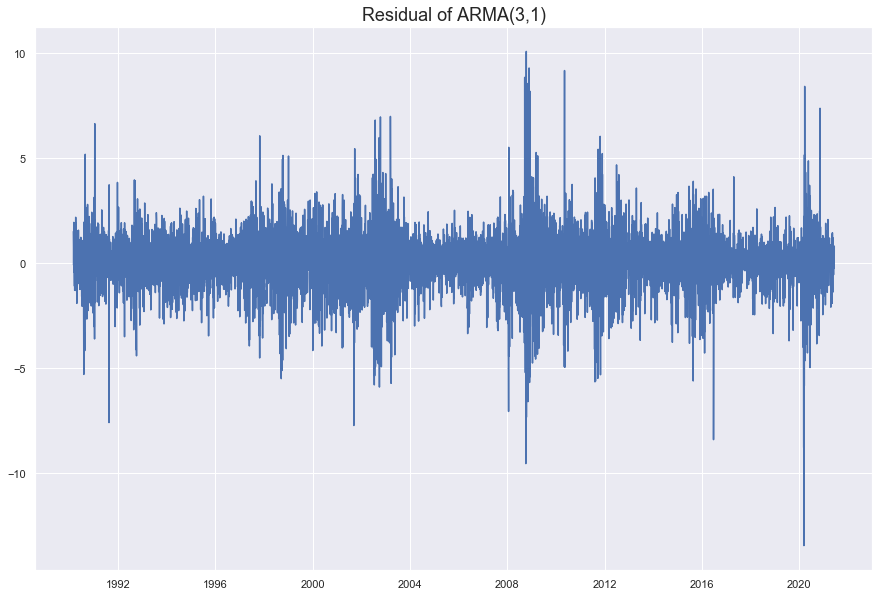

In [45]:
# The residuals plot
arma31_res=modelArma31.resid
plt.rcParams["figure.figsize"]=(15,10)

plt.plot(arma31_res, label="Residuals")
plt.title("Residual of ARMA(3,1)", size=18)
plt.show()


## GARCH Process on ARMA residuals

By analysing the plot of the above residuals generated by the `ARMA(3,1)` model, we can see that large changes at particular time step tend to cluster together and small changes at a particular time step are followed by small change in nearby time step. This indicates a volatility clustering or conditional heteroscedasticity. We are then going to fit that series with a `GARCH Model`.


###  GARCH parameter Estimation

In order to estimate the two parameters $p,q$ of the `GARCH(p,q) Model`, we shall use the `PACF` function on the `ARMA(3,1)` residuals.  As we show above, these parameters can be estimate by using the number of significant lags $m=\max(p,q)$ in the `PACF` plot. 



/Users/cyrillesimeu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


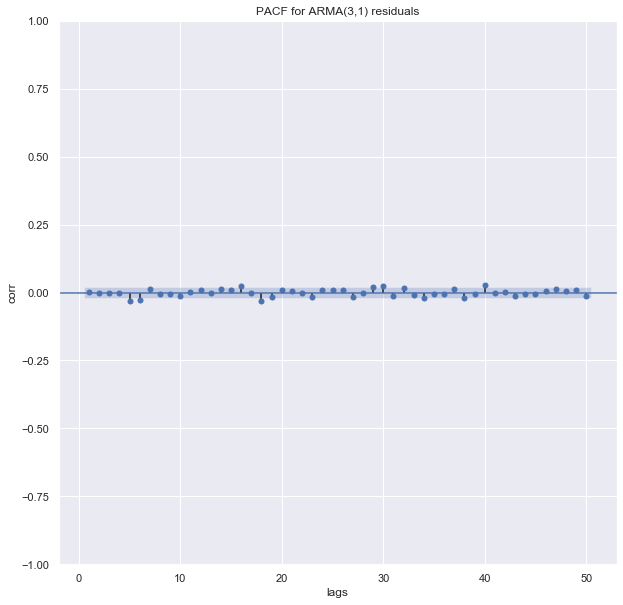

In [46]:
# PACF plot of the ARMA(3,1) residuals
# setting the figure size
plt.rcParams["figure.figsize"]=(10,10)

# The partial autocorrelation function of the squared returns
plot_pacf(arma31_res,zero=False, lags=50)
plt.xlabel('lags')
plt.ylabel('corr')
plt.title("PACF for ARMA(3,1) residuals")
plt.show()

As we can see in the above plot of the `PCAF` of the `ARMA(3,1)` residuals, there are no significant lags. So we will fit differents combinaisons of `GARCH(p,q) model` for $p,q\leq 3$  and get the best one by the use of information criteria.

### Looking for the best model

In [47]:
# Building the residuals dataframe
resid_df=prices.copy()
resid_df["Log_Return_resid"]=resid_df["Log_Return"].shift(1).loc[resid_df.index]
resid_df.at[r_train.index[0]:r_train.index[-1], "Log_Return_resid"]=arma31_res
resid_df


,Close,Return,Log_Return,Log_Return_vol,Log_Return_resid
Date,,,,,
1990-03-02,1860.000000,1.528384,1.516822,2.254965,1.516822
1990-03-05,1874.000000,0.752688,0.749870,0.539786,0.762020
1990-03-06,1872.000000,-0.106724,-0.106781,0.014871,-0.081754
1990-03-07,1880.000000,0.427350,0.426440,0.169144,0.502321
1990-03-08,1917.000000,1.968085,1.948969,3.739585,1.950660
...,...,...,...,...,...
2022-05-24,6253.140137,-1.660708,-1.674652,2.855493,1.162622
2022-05-25,6298.640137,0.727634,0.725000,0.503861,-1.674652
2022-05-26,6410.580078,1.777208,1.761600,3.050025,0.725000


In [48]:
table_of_garch_metric=pd.DataFrame( {"Model":["AIC","BIC", "Log-Likelihood"]}) 
table_of_garch_metric.set_index("Model", inplace=True)

for p in range(1,4):
    for q in range(1,4):
        print("#"*80,"\n")
        print(" "*30,"GARCH(%d,%d)" % (p,q)," "*40,"\n")
        print("#"*80)
        # define the model
        model=arch_model(resid_df["Log_Return_resid"][1:], p=p,q=q, vol="GARCH")
        # fitting the model
        model_result=model.fit(last_obs=r_test.index[0])
        # values of metric
        table_of_garch_metric["GARCH(%d,%d)" % (p,q)]=[model_result.aic, model_result.bic,model_result.loglikelihood]
        print(model_result.summary())
        
 
tab_garch=table_of_garch_metric.T
tab_garch

################################################################################ 

                               GARCH(1,1)                                          

################################################################################
Iteration:      1,   Func. Count:      6,   Neg. LLF: 12864.400969728114
Iteration:      2,   Func. Count:     16,   Neg. LLF: 12859.445922436655
Iteration:      3,   Func. Count:     23,   Neg. LLF: 12858.899795634035
Iteration:      4,   Func. Count:     31,   Neg. LLF: 12858.808194552745
Iteration:      5,   Func. Count:     40,   Neg. LLF: 12858.52528762239
Iteration:      6,   Func. Count:     47,   Neg. LLF: 12858.343629720215
Iteration:      7,   Func. Count:     55,   Neg. LLF: 12858.3436074341
Iteration:      8,   Func. Count:     62,   Neg. LLF: 12858.34283023479
Iteration:      9,   Func. Count:     68,   Neg. LLF: 12858.342825419448
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12858.3

Iteration:      2,   Func. Count:     18,   Neg. LLF: 12852.926447772828
Iteration:      3,   Func. Count:     28,   Neg. LLF: 12852.829590972726
Iteration:      4,   Func. Count:     37,   Neg. LLF: 12852.512621428847
Iteration:      5,   Func. Count:     46,   Neg. LLF: 12852.421034166986
Iteration:      6,   Func. Count:     54,   Neg. LLF: 12852.345411912922
Iteration:      7,   Func. Count:     63,   Neg. LLF: 12852.313228841691
Iteration:      8,   Func. Count:     72,   Neg. LLF: 12852.30706969454
Iteration:      9,   Func. Count:     79,   Neg. LLF: 12852.287458984063
Iteration:     10,   Func. Count:     86,   Neg. LLF: 12852.286657463204
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12852.28665746238
            Iterations: 10
            Function evaluations: 86
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                      
Dep. Variable:       Log_Return_resid   R-squared:     

Iteration:      1,   Func. Count:      8,   Neg. LLF: 12860.159934830794
Iteration:      2,   Func. Count:     21,   Neg. LLF: 12856.181105204385
Iteration:      3,   Func. Count:     31,   Neg. LLF: 12852.775470564153
Iteration:      4,   Func. Count:     42,   Neg. LLF: 12851.765507728305
Iteration:      5,   Func. Count:     53,   Neg. LLF: 12851.556855883811
Iteration:      6,   Func. Count:     63,   Neg. LLF: 12851.21991034233
Iteration:      7,   Func. Count:     73,   Neg. LLF: 12851.181424272852
Iteration:      8,   Func. Count:     82,   Neg. LLF: 12851.127370908735
Iteration:      9,   Func. Count:     92,   Neg. LLF: 12851.125661977876
Iteration:     10,   Func. Count:    100,   Neg. LLF: 12851.12032484418
Iteration:     11,   Func. Count:    108,   Neg. LLF: 12851.12026456753
Iteration:     12,   Func. Count:    116,   Neg. LLF: 12851.120253285637
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12851.120253285215
            Itera

Model,AIC,BIC,Log-Likelihood
"GARCH(1,1)",25724.685651,25752.713649,-12858.342825
"GARCH(1,2)",25726.685651,25761.720648,-12858.342825
"GARCH(1,3)",25728.685651,25770.727648,-12858.342825
"GARCH(2,1)",25714.573315,25749.608312,-12852.286657
"GARCH(2,2)",25716.573315,25758.615312,-12852.286657
"GARCH(2,3)",25718.573314,25767.622310,-12852.286657
"GARCH(3,1)",25714.240507,25756.282503,-12851.120253
"GARCH(3,2)",25714.987072,25764.036068,-12850.493536
"GARCH(3,3)",25713.059516,25769.115512,-12848.529758


Base on  `AIC` criterion, `GARCH(3,3)` is the fitted model with the best accuracy. But, having a look of others criteria such as `BIC` and `Log-Likelihood` criteria, the `GARCH(3,1)` is  the one with the best accuracy. However, neither `GARCH(3,3)` nor `GARCH(3,1)` has  significant coeddicients. As we can see, the best fitted model with significant parameters is `GARCH(2,1)`.

In [49]:
# define the GARCH(2,1) model
garch21_model=arch_model(resid_df["Log_Return_resid"][1:], p=2,q=1, vol="GARCH")
# fitting the GARCH(3,1) model
garch21_model_result=garch21_model.fit(last_obs=r_test.index[0])
garch21_model_result.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 12857.297761029893
Iteration:      2,   Func. Count:     18,   Neg. LLF: 12852.926447772828
Iteration:      3,   Func. Count:     28,   Neg. LLF: 12852.829590972726
Iteration:      4,   Func. Count:     37,   Neg. LLF: 12852.512621428847
Iteration:      5,   Func. Count:     46,   Neg. LLF: 12852.421034166986
Iteration:      6,   Func. Count:     54,   Neg. LLF: 12852.345411912922
Iteration:      7,   Func. Count:     63,   Neg. LLF: 12852.313228841691
Iteration:      8,   Func. Count:     72,   Neg. LLF: 12852.30706969454
Iteration:      9,   Func. Count:     79,   Neg. LLF: 12852.287458984063
Iteration:     10,   Func. Count:     86,   Neg. LLF: 12852.286657463204
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12852.28665746238
            Iterations: 10
            Function evaluations: 86
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:       Log_Return_resid   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12852.3
Distribution:                  Normal   AIC:                           25714.6
Method:            Maximum Likelihood   BIC:                           25749.6
                                        No. Observations:                 8160
Date:                Tue, Jun 14 2022   Df Residuals:                     8159
Time:                        23:01:46   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0503  1.233e-02      4.083  4.443e-05 [2.618e-02,7.452e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0371  1.006e-02      3.686  2.275e-04 [1.736e-02,5.679e-02]
alpha[1]       0.0542  1.629e-02      3.327  8.769e-04 [2.228e-02,8.614e-02]
alpha[2]       0.0531  2.290e-02      2.321  2.030e-02 [8.261e-03,9.802e-02]
beta[1]        0.8728  1.851e-02     47.150      0.000     [  0.837,  0.909]
============================================================================

Covariance estimator: robust
"""

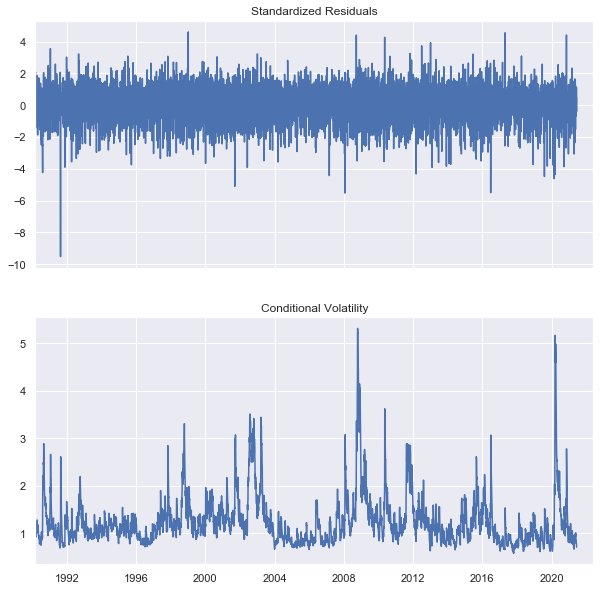

In [50]:
# Plot the fitted result
garch21_model_result.plot()
plt.show()

### Conditional volatility

In [51]:
garch21_vol=garch21_model_result.conditional_volatility
garch21_vol[:r_train.index[-1]]

Date
1990-03-05    0.971139
1990-03-06    0.967904
1990-03-07    0.939494
1990-03-08    0.905257
1990-03-09    0.979271
                ...   
2021-06-07    0.787105
2021-06-08    0.765615
2021-06-09    0.745871
2021-06-10    0.723986
2021-06-11    0.707452
Freq: B, Name: cond_vol, Length: 8160, dtype: float64

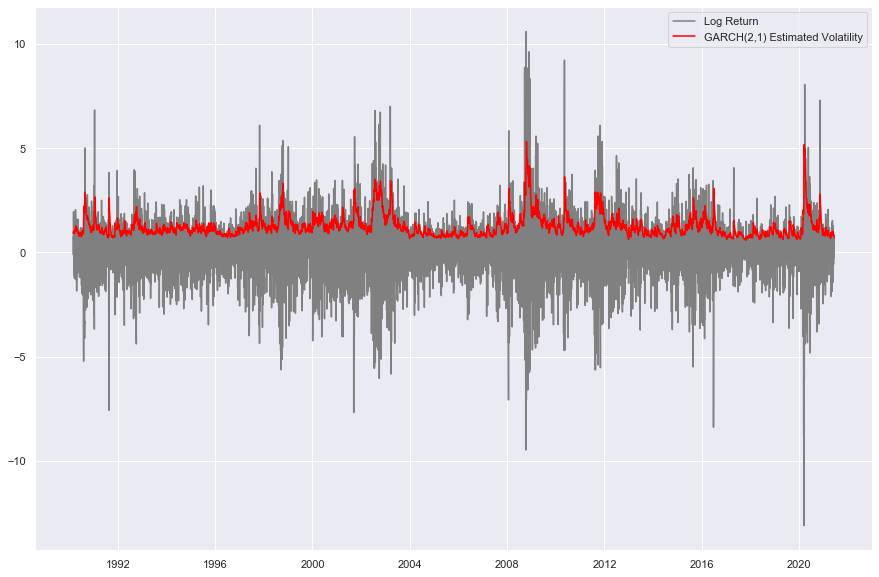

In [52]:
# Plotting log return and volatility


plt.rcParams["figure.figsize"]=(15,10)

# Plotting the actual Log_Return

plt.plot(r_train["Log_Return"][1:], color="grey",label="Log Return")
plt.plot(garch21_vol, color="red",label="GARCH(2,1) Estimated Volatility")
plt.legend()
plt.show()


### Prediction of ARMA(3,1)+GARCH(2,1) model


In [53]:
from arch.__future__ import reindexing

# Forecasting and confidence intervals

# Forecasting volatility of test set

resid_forecasts=garch21_model_result.forecast().residual_variance.loc[r_test.index]
resid_forecasts


,h.1
Date,
2021-06-14,0.547063
2021-06-15,0.548284
2021-06-16,0.522355
2021-06-17,0.498942
2021-06-18,0.475011
...,...
2022-05-24,1.874996
2022-05-25,1.900697
2022-05-26,1.878883


We now compute the new confidence interval.

In [54]:
# Confidence interval

arma31_garch21_predictions=modelArma31Predictions.copy()
arma31_garch21_predictions["lower Log_Return"]=arma31_garch21_predictions["Predictions"]- resid_forecasts.values.reshape(-1,)
arma31_garch21_predictions["Forecast_Volatility"]=resid_forecasts.values.reshape(-1,)
arma31_garch21_predictions["upper Log_Return"]=arma31_garch21_predictions["Predictions"] + resid_forecasts.values.reshape(-1,)
arma31_garch21_predictions


,lower Log_Return,upper Log_Return,Predictions,Forecast_Volatility
2021-06-14,-0.559041,0.535085,-1.197771e-02,0.547063
2021-06-15,-0.543091,0.553477,5.192821e-03,0.548284
2021-06-16,-0.566355,0.478354,-4.400025e-02,0.522355
2021-06-17,-0.476267,0.521618,2.267549e-02,0.498942
2021-06-18,-0.485951,0.464072,-1.093948e-02,0.475011
...,...,...,...,...
2022-05-24,-1.874996,1.874996,-2.138233e-54,1.874996
2022-05-25,-1.900697,1.900697,1.306741e-54,1.900697
2022-05-26,-1.878883,1.878883,-7.985901e-55,1.878883
2022-05-27,-1.859974,1.859974,4.880433e-55,1.859974


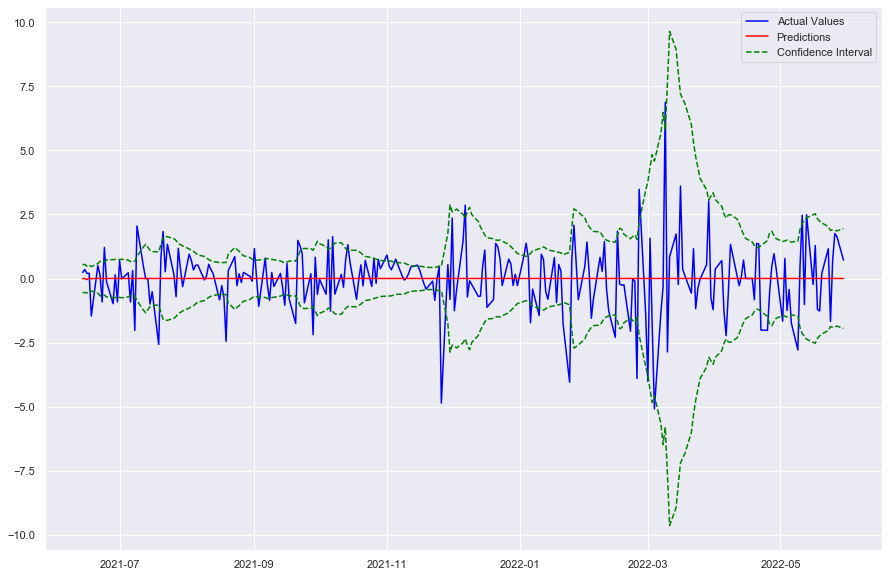

In [55]:
# Plotting the forecasts and confidence interval

plt.rcParams["figure.figsize"]=(15,10)

# Plotting the actual Log_Return

plt.plot(r_test["Log_Return"], color="blue",label="Actual Values")


# Plotting the forecasted Log_Return from ARMA(3,1)

plt.plot(arma31_garch21_predictions["Predictions"], color="red",label="Predictions")

# Plotting the confidence interval generated by the GARCH Model

plt.plot(arma31_garch21_predictions["lower Log_Return"], color="green",linestyle="--",label="Confidence Interval")
plt.plot(arma31_garch21_predictions["upper Log_Return"], color="green",linestyle="--")
plt.legend()
plt.show()


## Forecasting

In progress

## Conclusion
In progress

## References

[[1] __Time series analysis, UCLouvain lecture LSTAT2170.__](https://uclouvain.be/cours-2021-lstat2170) 

[[2]  __Statistical Forecasting for Time Series Data Part 5: ARMA+GARCH model for Time Series Forecasting.__](https://towardsai.net/p/data-visualization/statistical-forecasting-for-time-series-data-part-5-armagarch-model-for-time-series-forecasting) 

[[3] __ARCH/GARCH Volatility Forecasting.__](https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/):  

[[4] __ARCHModeling.__](https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html)



